# Subscription Covariates Model

Models such as `BetaGeoNBDModel` work well for retail transactions, but subscription renewals require a different approach. In ["Incorporating Time-Varying Covariates in
a Simple Mixture Model for
Discrete-Time Duration Data"](https://www.brucehardie.com/notes/037/time-varying_covariates_in_BG.pdf), Fader & Hardie propose an ideal model for this very purpose. The research note derives a model supporting time-varying covariates, but with this [methodology](https://brucehardie.com/notes/019/time_invariant_covariates.pdf), it can be easily extended to support static covariates as well.


### Setup Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sb
import xarray as xr
from fastprogress.fastprogress import progress_bar
import pymc as pm
import pytensor as pt
from scipy.stats import describe

from pymc_marketing import clv
from pymc_marketing.prior import Prior

In [2]:
# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
seed = sum(map(ord, "Subscription Covariates Model"))
rng = np.random.default_rng(seed)

### Generate Data
We will be recreating the test dataset from the [`ShiftedBetaGeoModelIndividual` notebook](https://www.pymc-marketing.io/en/stable/notebooks/clv/sBG.html) for comparison. This dataset consists of 2,000 customers in two groups - Regular and High-end. Both groups contain 1,000 customers.

The following dataframe contains the percent of customers still active in each time period for both groups:

In [4]:
df = pd.DataFrame(
    {
        "regular": [
            100.0,
            63.1,
            46.8,
            38.2,
            32.6,
            28.9,
            26.2,
            24.1,
            22.3,
            20.7,
            19.4,
            18.3,
            17.3,
        ],
        "highend": [
            100.0,
            86.9,
            74.3,
            65.3,
            59.3,
            55.1,
            51.7,
            49.1,
            46.8,
            44.5,
            42.7,
            40.9,
            39.4,
        ],
    }
)
df

regular  highend
0     100.0    100.0
1      63.1     86.9
2      46.8     74.3
3      38.2     65.3
4      32.6     59.3
5      28.9     55.1
6      26.2     51.7
7      24.1     49.1
8      22.3     46.8
9      20.7     44.5
10     19.4     42.7
11     18.3     40.9
12     17.3     39.4

Note time period 0 is specific to each customer: Time 0 for one customer may be Oct 2024, and Time 0 for another could be Jan 2025. It is the responsibility of the user to index the modeling data by the number of active time periods for each customer. The first seven time periods will be used for model fitting, and the remaining 6 for validation.

The next three cells contain a data generation function, which is then parametrized to create the regular and highend customers. Both customer groups are then concatenated into a `pandas` dataframe for modeling.

In [5]:
def individual_data_from_percentage_alive(percentage_alive, initial_customers):
    n_alive = np.asarray(percentage_alive / 100 * initial_customers, dtype=int)

    died_at = np.zeros((initial_customers,), dtype=int)
    counter = 0
    for t, diff in enumerate((n_alive[:-1] - n_alive[1:]), start=1):
        died_at[counter : counter + diff] = t
        counter += diff

    censoring_t = t + 1
    died_at[counter:] = censoring_t

    return died_at

In [6]:
T = 8  # In the paper only the first 7 years (plus current year) are included in the model.

truncated_df = df[:T]
initial_customers = 1000  # Seems to be what F&H use, according to Appendix B
churn_highend = individual_data_from_percentage_alive(
    truncated_df["highend"], initial_customers
)
churn_regular = individual_data_from_percentage_alive(
    truncated_df["regular"], initial_customers
)

In [7]:
dataset_highend = pd.DataFrame(
    {
        "customer_id": np.arange(initial_customers),
        "t_churn": churn_highend,
        "T": T,
        "group": "highend",
    }
)

dataset_regular = pd.DataFrame(
    {
        "customer_id": np.arange(initial_customers),
        "t_churn": churn_regular,
        "T": T,
        "group": "regular",
    }
)

dataset = pd.concat([dataset_highend,dataset_regular])

dataset[::200]

customer_id  t_churn  T    group
0              0        1  8  highend
200          200        2  8  highend
400          400        4  8  highend
600          600        8  8  highend
800          800        8  8  highend
0              0        1  8  regular
200          200        1  8  regular
400          400        2  8  regular
600          600        3  8  regular
800          800        8  8  regular

# Model Fitting

Fader & Hardie refer to this model as the Grassia(II)-Geometric + covariates model. It has the following assumptions:

1. Customers are active for a discrete number of $t$ subscription periods, then permanently cancel their subscription at time period $T$.
   
2. Difference between customers are characterized by a Gamma distribution with shape $r$ and scale $\alpha$.
   
3. Time-varying covariates for each customer are described by $C(t)$:
   $$C(t)=\sum_{j=1}^{t} e^{z(j)\beta}$$
   Where $z(j)$ denotes the vector of covariates at time $j$, and $\beta$ the coefficients for these covariates. If no covariates are specified, this expression reduces to $t$.
   
4. Parameters $r$, $\alpha$, and $\beta$ do not vary over time.
   
5. Random variable $T$ for subscription cancellations is described by the following following probability mass function:
    $$P(T(=t|r,\alpha,\beta;Z(t)) = (\frac{\alpha}{\alpha+C(t-1)})^{r} - (\frac{\alpha}{\alpha+C(t)})^{r} $$

6. The probability a customer is still active in time period $t$ is characterized by the following survival function:
   $$S(t|r,\alpha,\beta;Z(t)) = (\frac{\alpha}{\alpha+C(t)})^{r} $$

7. To include static covariates, simply modify the $\alpha$ parameter as shown:
   $$\alpha=\alpha_0e^{-\gamma*x} $$
   Where $x$ denotes the static covariate arrays for each customer, with $\gamma$ coefficients capturing covariate impacts. 

For detailed derivations of this model, refer back to the research notes.

In [8]:
censored = dataset["t_churn"] == dataset["T"]

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  2000 non-null   int64 
 1   t_churn      2000 non-null   int64 
 2   T            2000 non-null   int64 
 3   group        2000 non-null   object
dtypes: int64(3), object(1)
memory usage: 78.1+ KB


In [258]:
def logp(r, alpha, t):
    return r*(-pt.tensor.log(alpha+t-1) + pt.tensor.log(alpha+t))
def log_survival_fn(r, alpha, t):
    return r * (pt.tensor.log(alpha) - pt.tensor.log(alpha + t))


# coords = {
#     "churn_customer": dataset["customer_id"][~censored],
#     "active_customer": dataset["customer_id"][censored],
# }
coords ={"customer_id": dataset["customer_id"]}

with pm.Model(coords=coords) as model:
    # This config is the least informative that does not cause divergences for 2k customers.
    alpha = pm.Gamma("alpha",alpha=5,beta=5)
    r = pm.Gamma("r", alpha=5,beta=5)

    # TODO: Censored should be supported now in the case of no covariates: https://github.com/pymc-labs/pymc-marketing/blob/main/pymc_marketing/clv/models/shifted_beta_geo.py#L143
    
    #churn_raw = clv.distributions.GrassiaIIGeometric("churn",r=r, alpha=alpha, observed = dataset["t_churn"][~censored], dims=("churn_customer",))
    #cens = pm.Potential("censored",log_survival_fn(r, alpha, dataset["t_churn"][censored]), dims=("active_customer",))
    churn_raw = clv.distributions.GrassiaIIGeometric.dist(r=r, alpha=alpha)
    cens = pm.Censored(
        "censored",
        churn_raw,
        lower=None,
        upper=dataset["T"],
        observed = dataset["t_churn"],
        dims=("customer_id",)
    )

    idata = pm.sample(idata_kwargs={"log_likelihood": True})

    # These lines are not required for notebook dev, but will need to be tested when model is built
    # idata = pm.sample_prior_predictive()
    
    # idata.extend(
    #     pm.sample(random_seed=seed, idata_kwargs={"log_likelihood": True})
    # )
    # idata.extend(pm.sample_posterior_predictive(idata))
    

Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'alpha_log__': array(0.6381935), 'r_log__': array(-0.01051991)}

Logp initial evaluation results:
{'alpha': -1.41, 'r': -0.13, 'censored': nan}
You can call `model.debug()` for more details.

In [12]:
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  1.346  0.541   0.440    2.342       0.01    0.007    3005.0    2670.0   
r      0.005  0.002   0.001    0.010       0.00    0.000    2667.0    2227.0   

       r_hat  
alpha    1.0  
r        1.0

In [13]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'r'}>],
      dtype=object)

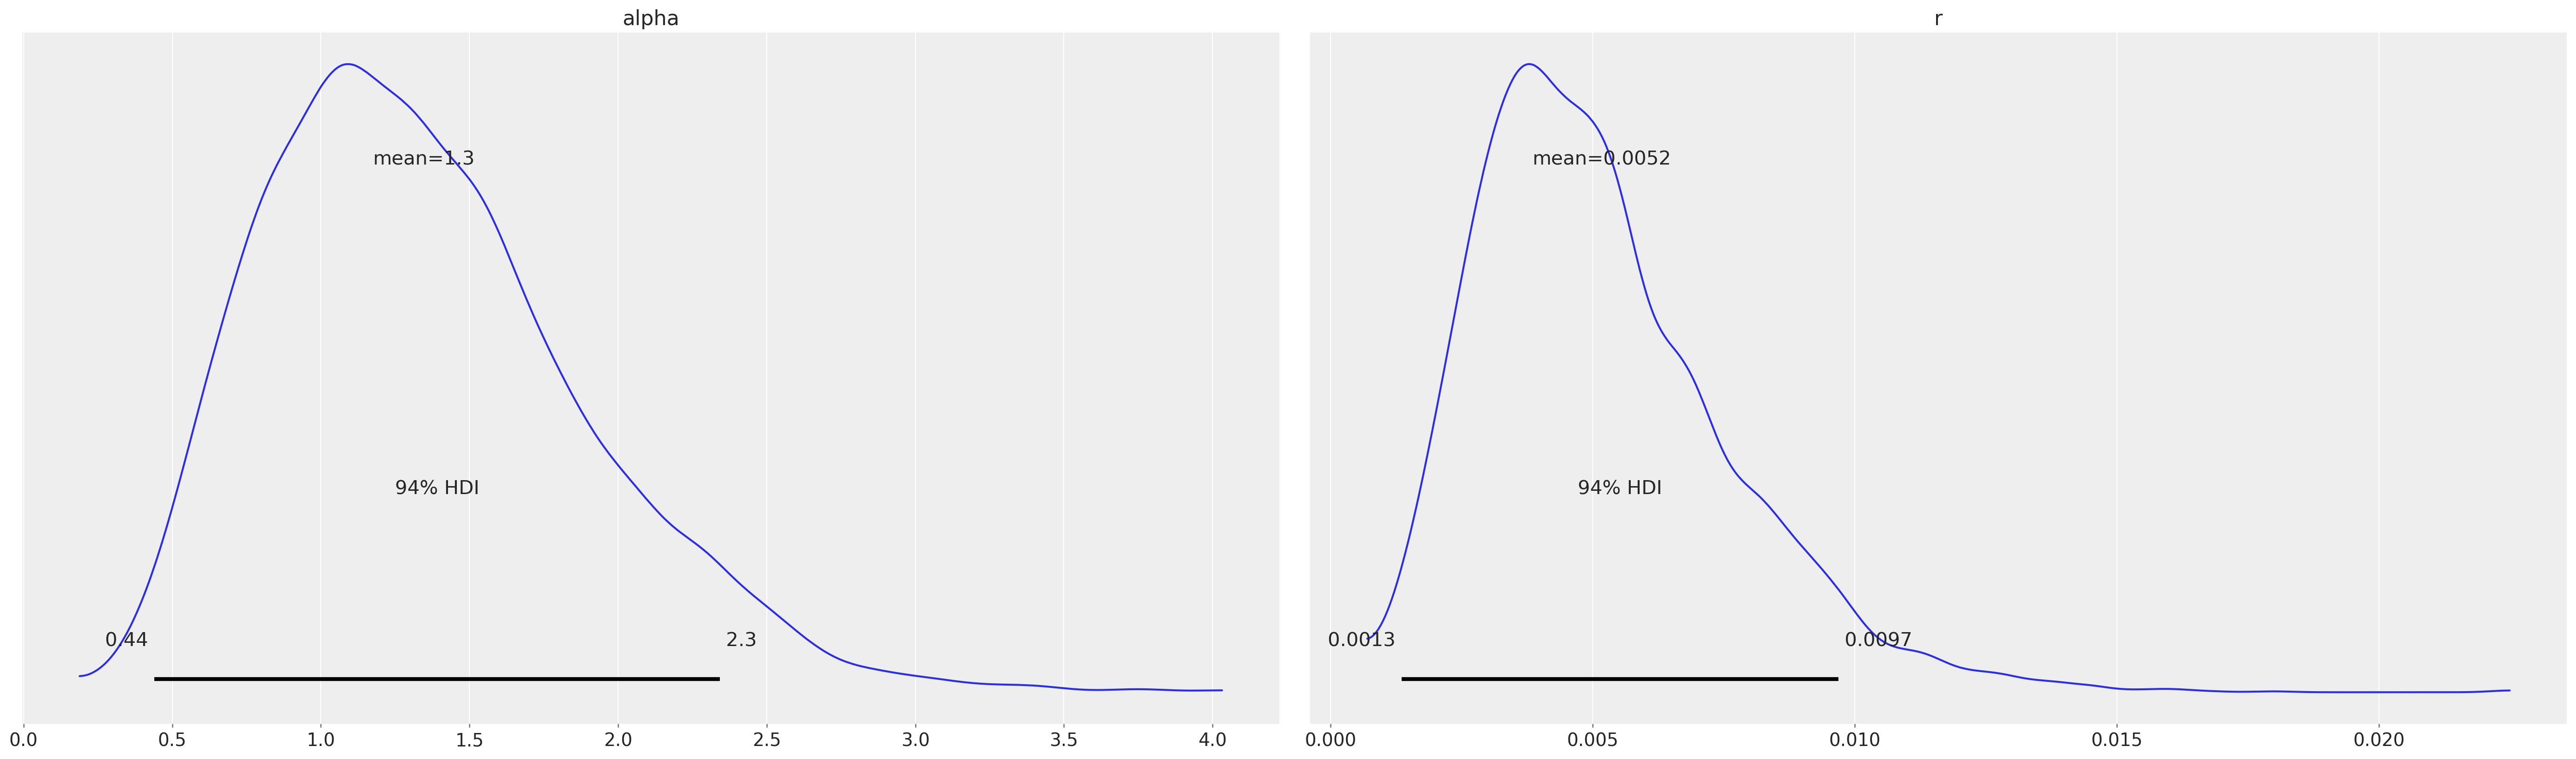

In [14]:
az.plot_posterior(idata)

### Prior Selection and RNG Debugging

In [249]:
with model:
    ppc = pm.sample_posterior_predictive(idata)

/var/folders/fg/0gjlwtr11dd51xt6hkb8qw6h0000gn/T/ipykernel_4684/575134001.py:2: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(idata)
Sampling: [churn]


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data

data describe: DescribeResult(nobs=5072000, minmax=(1, 830149), mean=1540.8525954258675, variance=106184195.7038396, skewness=20.21779869252089, kurtosis=617.4374921218258)


<Axes: >

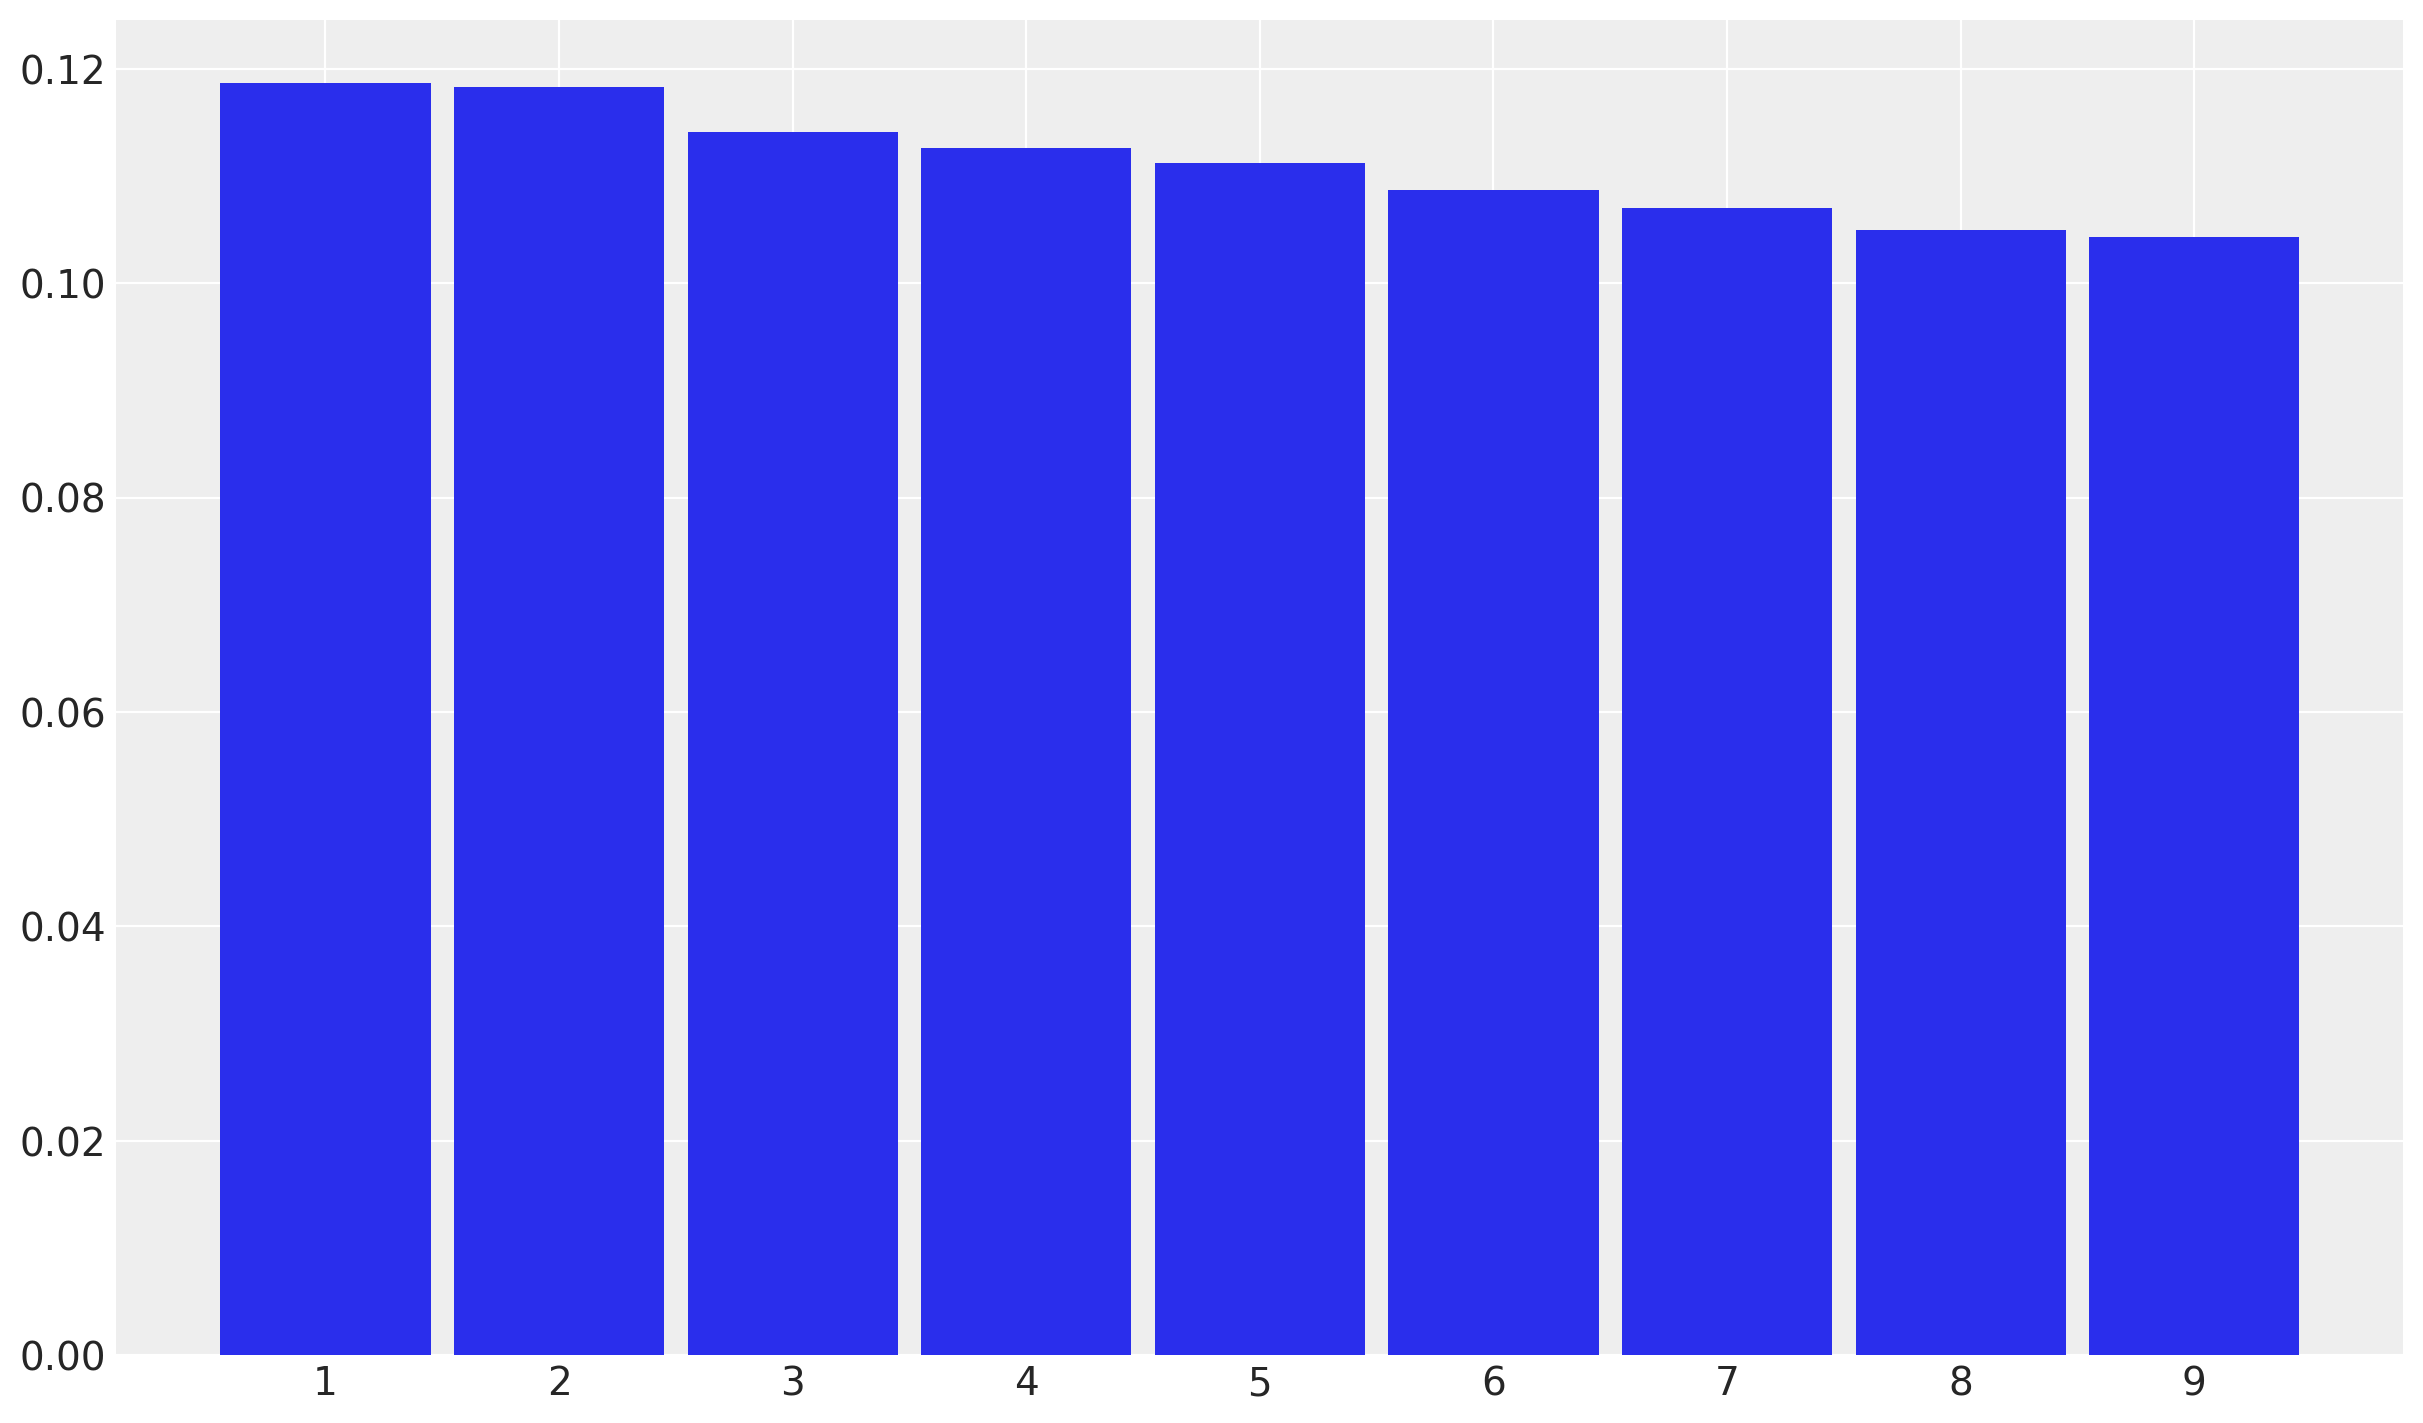

In [247]:
ppc_val = ppc.posterior_predictive["churn"].values.flatten()

print(f"data describe: {describe(ppc_val)}")

clipped_ppc_val = ppc_val[ppc_val<100]
az.plot_dist(ppc_val[ppc_val<10])

<Axes: >

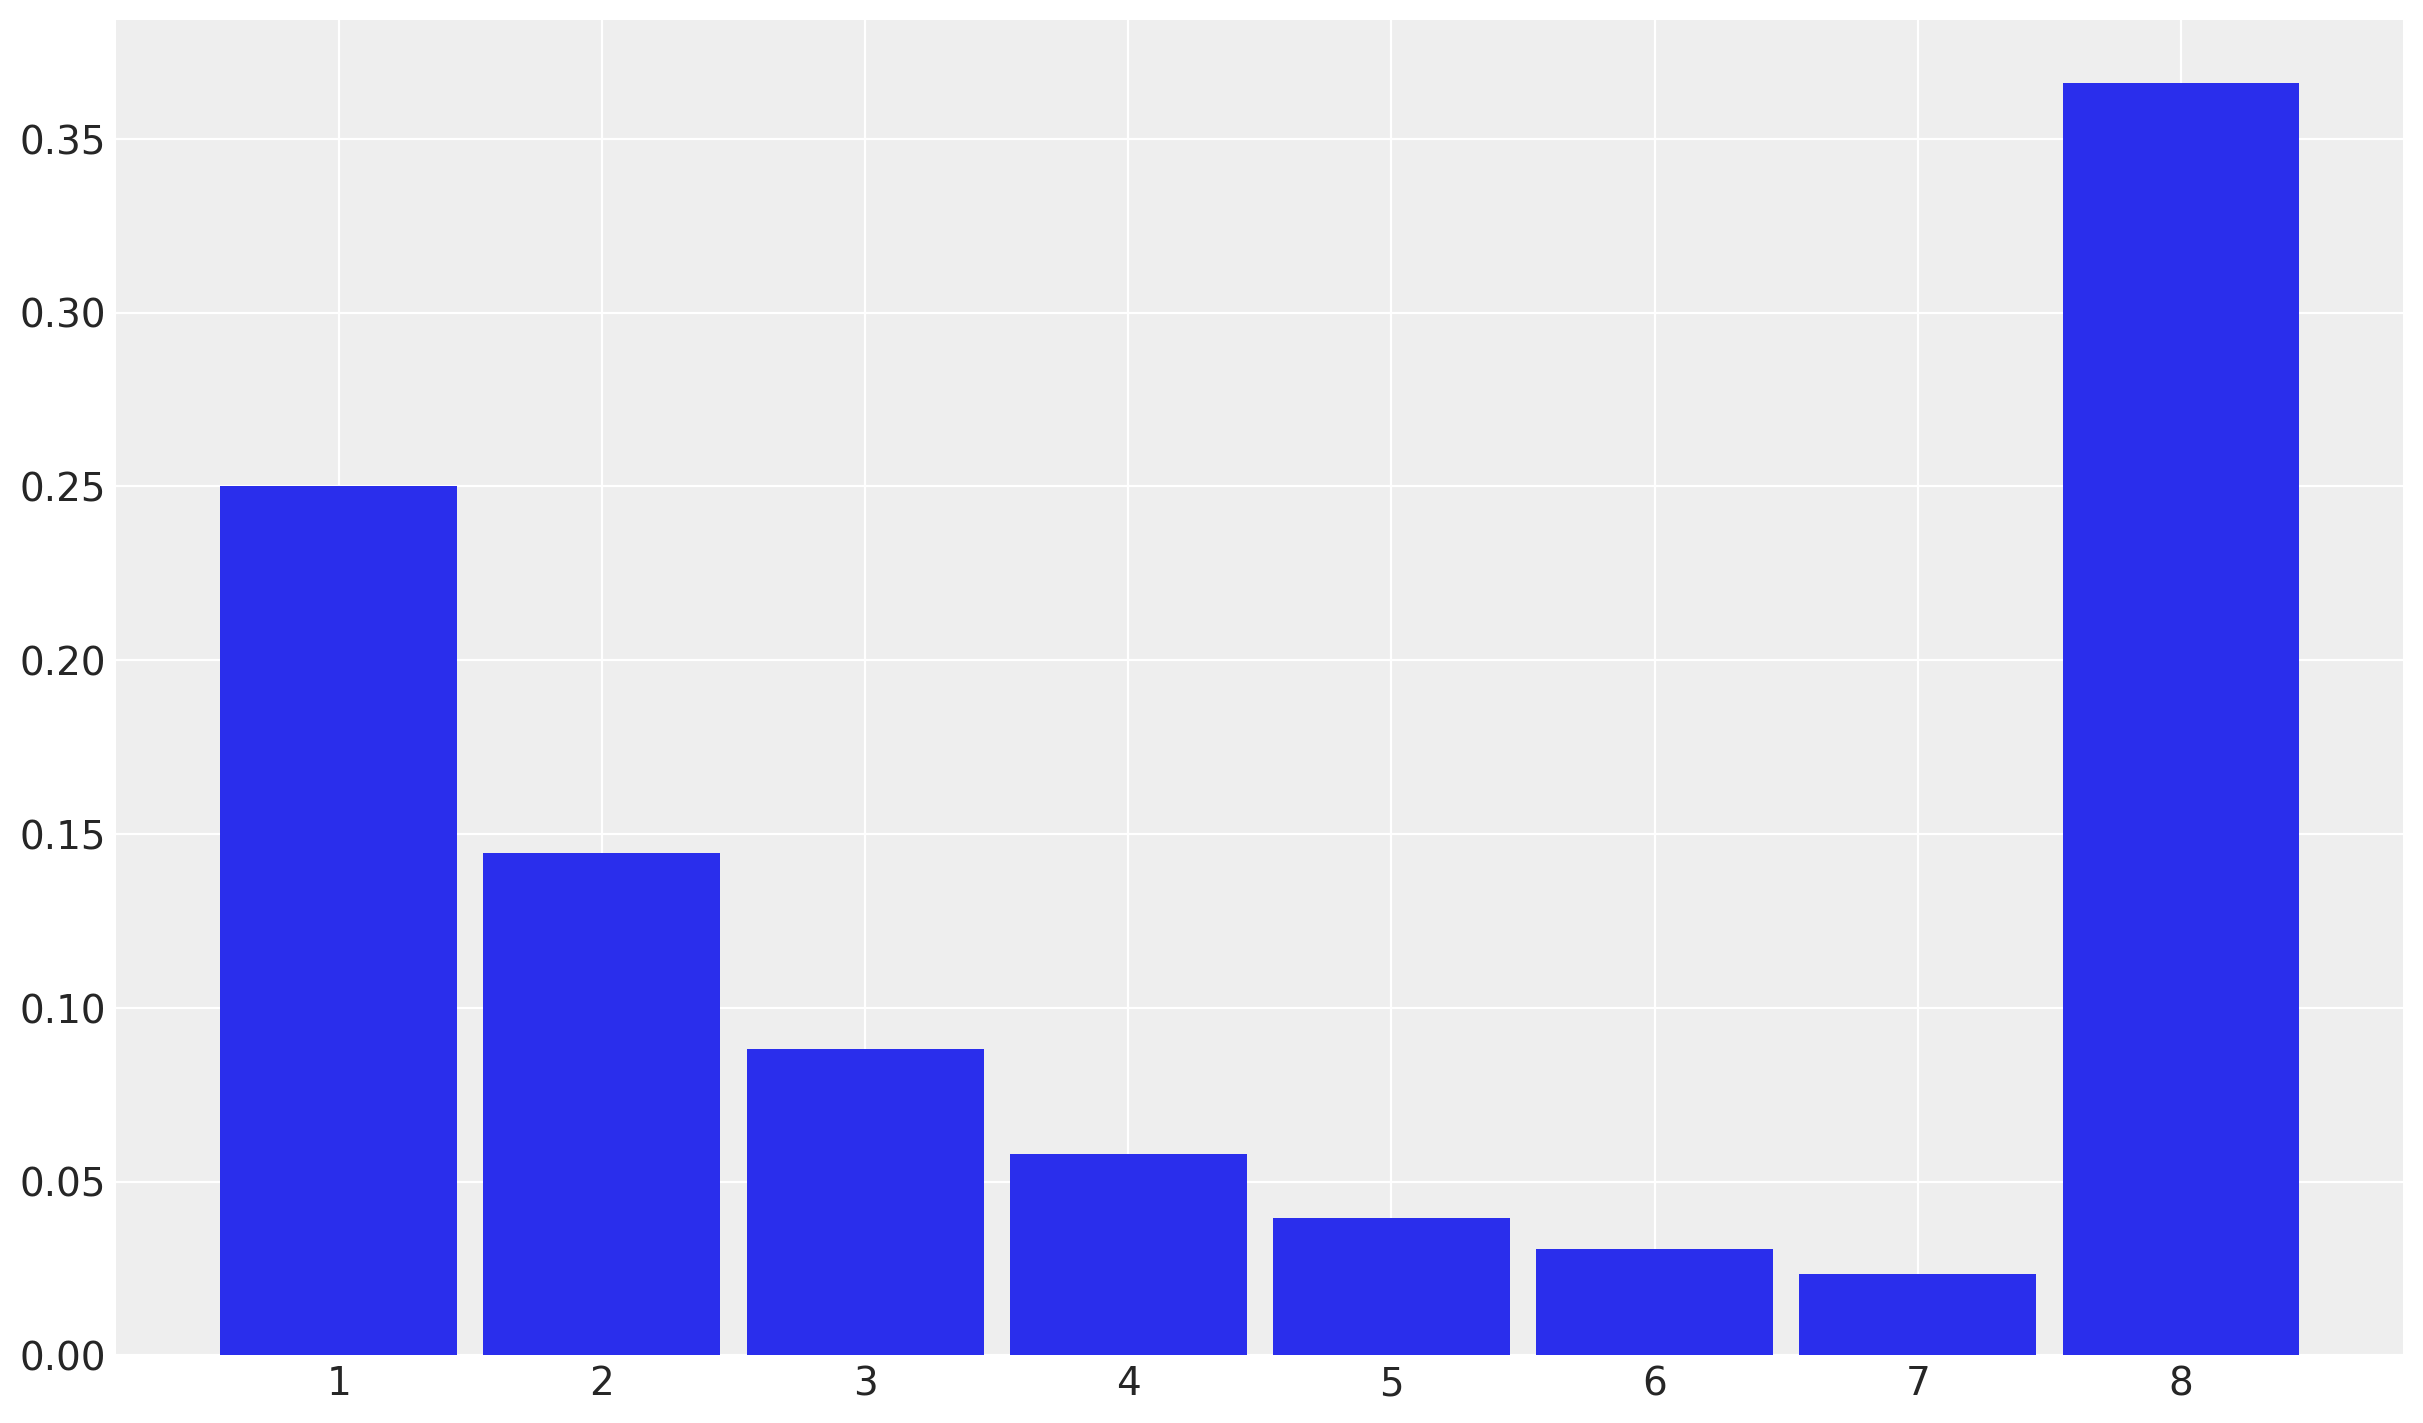

In [248]:
az.plot_dist(dataset["t_churn"])

# Covariate Data Generation Code
Incorporate this code into the Data Generation section for covariate development.

In [8]:
# Set random seed
rng = np.random.seed(45)

# Number of customers
N = 1000

# customer IDs
customer_id = np.array(np.arange(N))

# define probabiilty distributions
demographic_dist = pm.Bernoulli.dist(p=.5,rng=rng)
t_periods_dist = pm.Geometric.dist(p=.5, rng=rng)
active_dist = pm.Bernoulli.dist(p=.3,rng=rng)
n_purchases_dist = pm.Poisson.dist(mu=1, rng=rng)
avg_purchase_price_dist = pm.Gamma.dist(alpha=10, beta=1, rng=rng)

# draws for each customer
demographic = pm.draw(demographic_dist,draws=N)
t_periods = 13 - pm.draw(t_periods_dist,draws=N)
active = pm.draw(active_dist,draws=N)

In [9]:
# create time periods for each customer
customer_id_col = np.array([])

for idx in zip(customer_id, t_periods):
    customer_id_col = np.concatenate((customer_id_col, np.repeat(idx[0], idx[1])), axis=0)

n_time_periods = len(customer_id_col)

ValueError: negative dimensions are not allowed

In [ ]:
# draws for each time period
n_purchases = pm.draw(n_purchases_dist, draws=n_time_periods)
avg_purchase_price = pm.draw(avg_purchase_price_dist, draws=n_time_periods)

In [ ]:
customer_df = pd.DataFrame(
    {
        "customer_id": customer_id,
        "demographic": demographic,
        "active": active,
    }
)

time_period_df = pd.DataFrame(
    {
        "customer_id": customer_id_col,
        "monthly_purchases": n_purchases,
        "avg_price": avg_purchase_price,
    }
)

In [ ]:
customer_df

In [ ]:
time_period_df